In [63]:
import pandas as pd
import numpy as np
import bz2
import matplotlib.pyplot as plt
import seaborn as sns

import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dense ,Embedding , Dropout , Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence  import pad_sequences
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import re
import gc #garbage collector


### EDA

In [73]:
with bz2.open('train.ft.txt.bz2', 'rt', encoding='utf-8', errors='ignore') as file:
    data = file.readlines()


In [3]:
df = pd.DataFrame(data, columns = ['sent'])

In [4]:
df.head()

,sent
0,__label__2 Stuning even for the non-gamer: Thi...
1,__label__2 The best soundtrack ever to anythin...
2,__label__2 Amazing!: This soundtrack is my fav...
3,__label__2 Excellent Soundtrack: I truly like ...
4,"__label__2 Remember, Pull Your Jaw Off The Flo..."


In [5]:
df['label'] = df['sent'].apply(lambda x:  x.split(' ')[0][-1])

In [6]:
df.head()

,sent,label
0,__label__2 Stuning even for the non-gamer: Thi...,2
1,__label__2 The best soundtrack ever to anythin...,2
2,__label__2 Amazing!: This soundtrack is my fav...,2
3,__label__2 Excellent Soundtrack: I truly like ...,2
4,"__label__2 Remember, Pull Your Jaw Off The Flo...",2


In [7]:
df['sent'] = df['sent'].apply(lambda x : (' '.join(x.split(' ')[1:])).strip())

In [8]:
df.head(3)

,sent,label
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2


In [9]:
df['label'] = df['label'].astype('int')

In [30]:
df['label'] = df['label'] -1

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   sent    object
 1   label   int32 
dtypes: int32(1), object(1)
memory usage: 41.2+ MB


In [32]:
df['label'].value_counts()

label
1    1800000
0    1800000
Name: count, dtype: int64

(array([1800000.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1800000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

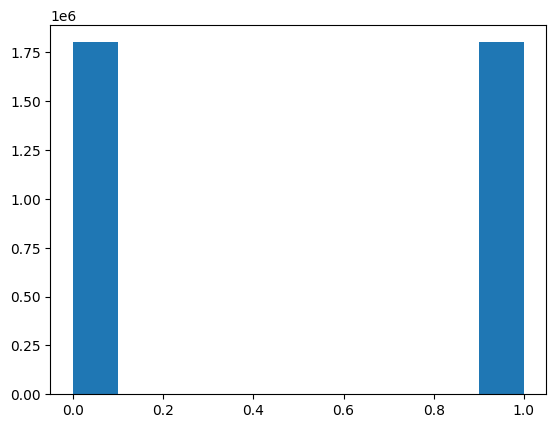

In [33]:
plt.hist(df['label'])

In [34]:
df.isnull().sum()

sent     0
label    0
dtype: int64

### data preparation

In [35]:
def normalize(sentence):
    
       
    ###   getting rid of URLs
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    text = re.sub(url_pattern, '', sentence)
    
    ###   keep only letters
    text = re.sub('[^a-zA-Z]',' ',text)

    ###  turn all into lower case
    text = text.lower()
    
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [15]:
df['sent'] = df['sent'].apply(normalize)


In [16]:
y_data = df['label']
x_data = df['sent']

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [18]:
type(x_train)

pandas.core.series.Series

In [19]:
train_texts = x_train
test_texts = x_test

### tokenize and pad sequence

In [21]:
max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

x_train = tokenizer.texts_to_sequences(train_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

In [23]:
x_train = np.array(x_train)
print(x_train.shape)
x_test = np.array(x_test)
print(x_test.shape)
y_train = np.array(y_train)
print(y_train.shape)
y_test = np.array(y_test)
print(y_test.shape)

(2880000, 100)
(720000, 100)
(2880000,)
(720000,)


In [36]:
y_train = y_train -1
y_test =y_test -1

### the model

In [49]:
model = Sequential()
model.add(Input(shape=(max_sequence_length,)))  # Explicitly specify the input shape
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(rate=0.2))  
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 391,297 (1.49 MB)

 Trainable params: 391,297 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size=2048, verbose=1, validation_split=.1)

Epoch 1/2
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2876s 2s/step - accuracy: 0.8550 - loss: 0.3237 - val_accuracy: 0.9104 - val_loss: 0.2193
Epoch 2/2
 380/1266 ━━━━━━━━━━━━━━━━━━━━ 32:06 2s/step - accuracy: 0.9126 - loss: 0.2142

KeyboardInterrupt: 

### evaluation

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

loss,accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 872s 39ms/step - accuracy: 0.9165 - loss: 0.2059
Loss: 0.2059135138988495
Accuracy: 0.9164263606071472


In [56]:
prediction=model.predict(x_test)
y_pred=np.where(prediction>=.5,1,0)
df1=pd.DataFrame()
df1['actual'],df1['pred']=y_test,y_pred

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 968s 43ms/step


In [64]:
def model_evaluation(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, f1, cm

In [59]:
df1.head()

,actual,pred
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0


In [66]:
accuracy_score(y_test, y_pred)


0.9164263888888889

In [67]:
precision_score(y_test, y_pred, average='weighted')

0.9164330793953727

In [68]:
recall_score(y_test, y_pred, average='weighted')

0.9164263888888889

In [69]:
f1_score(y_test, y_pred, average='weighted')

0.9164261745372063

In [71]:
CM =confusion_matrix(y_test, y_pred)
CM

array([[330382,  29377],
       [ 30796, 329445]], dtype=int64)

<Axes: >

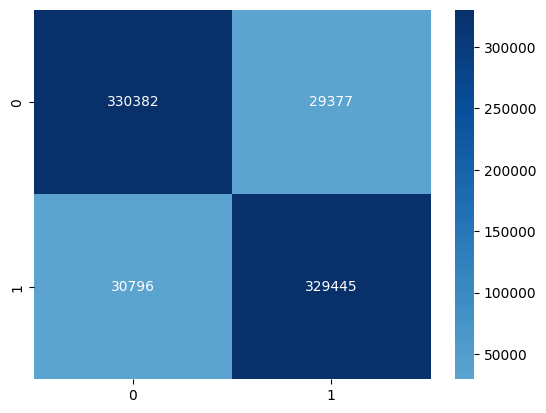

In [72]:
sns.heatmap(CM,annot=True,center = True,fmt='g',cmap='Blues')


In [55]:
model.save('Amazon sentiment analysis.h5')
print('saved')

saved
